![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller de D'sharlie Sanchez: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de bicicletas durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip), [dicccionario de datos](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset#).

### Datos prestamo de bicicletas

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [12]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz
import matplotlib.pyplot as plt

In [3]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/Dsharlie/ML-NLP/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)

# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)

# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour

# Visualización de los datos
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables "season" y "hour", escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [4]:
# Celda 1.1
bikes.groupby('season').total.mean()

season
1    116.343261
2    215.251372
3    234.417124
4    198.988296
Name: total, dtype: float64

In [5]:
# Celda 1.2
bikes.groupby('hour').total.mean()

hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: total, dtype: float64

In [6]:
# Calcular el promedio agrupado por hora
promedio_por_hora = bikes.groupby('hour')['total'].mean()

# Encontrar el máximo y mínimo
maximo = promedio_por_hora.max()
minimo = promedio_por_hora.min()

print("Máximo:", maximo)
print("Mínimo:", minimo)

Máximo: 468.765350877193
Mínimo: 6.407239819004525


In [7]:
# Calcular el percentil 75
percentil_75 = promedio_por_hora.quantile(0.75)

print("Percentil 75:", percentil_75)

Percentil 75: 256.828399122807


In [8]:
# variable 'season'
season_stats = bikes.groupby('season')['total'].agg(['min', 'max', 'mean', 'median', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)])
season_stats.columns = ['Mínimo', 'Máximo', 'Mean', 'Mediana', 'Percentil 25', 'Percentil 75']
print("Estadísticas para la variable 'season' (Estación):\n", season_stats)

# variable 'hour'
hour_stats = bikes.groupby('hour')['total'].agg(['min', 'max', 'mean', 'median', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)])
hour_stats.columns = ['Mínimo', 'Máximo', 'Mean', 'Mediana', 'Percentil 25', 'Percentil 75']
print("\nEstadísticas para la variable 'hour' (Hora del día):\n", hour_stats)

Estadísticas para la variable 'season' (Estación):
         Mínimo  Máximo        Mean  Mediana  Percentil 25  Percentil 75
season                                                                 
1            1     801  116.343261     78.0          24.0         164.0
2            1     873  215.251372    172.0          49.0         321.0
3            1     977  234.417124    195.0          68.0         347.0
4            1     948  198.988296    161.0          51.0         294.0

Estadísticas para la variable 'hour' (Hora del día):
       Mínimo  Máximo        Mean  Mediana  Percentil 25  Percentil 75
hour                                                                 
0          2     283   55.138462     41.0         24.00         74.50
1          1     168   33.859031     19.0         11.00         46.00
2          1     119   22.899554     11.0          5.00         32.00
3          1      66   11.757506      6.0          3.00         15.00
4          1      28    6.407240      6.0

De acuerdo a los resultados anteriores podemos inferir que en verano es la temporada en que mayor numero de bicicletas se alquilan y en invierno se alquilan mucho menos veces que en las demás temporadas. Tambien se puede inferir que a las 17 horas se tiene el mayor numero de alquiler de bicicletas, mientras que entre las 23 horas y las 6 horas vemos que disminuye drasticamente el alquiler de estas.

Las horas 12,13,16,17,18 y 19 ocupan las horas con el mayor numero de alquiler de bicicletas.

### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica del número de bicicletas rentadas promedio para cada valor de la variable "hour" (hora) cuando la variable "season" es igual a 1 (invierno) e igual a 3 (verano), respectivamente. Analice y escriba sus hallazgos.

<Axes: xlabel='hour'>

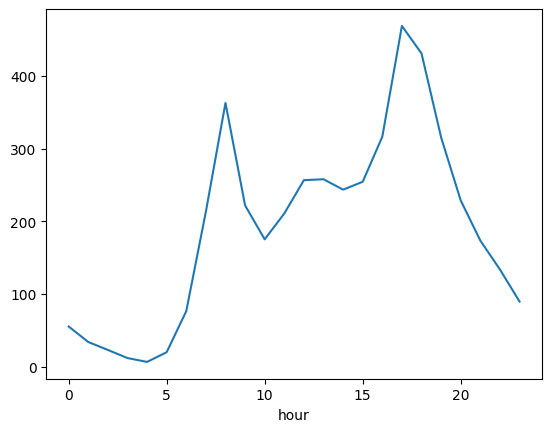

In [9]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot()

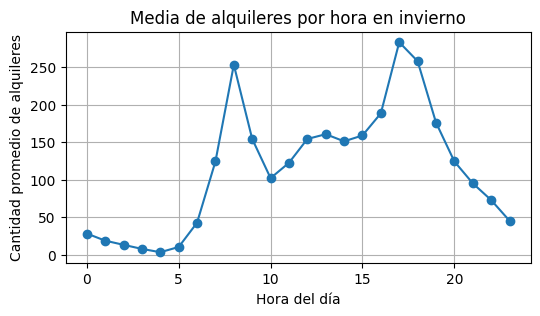

In [13]:
# Celda 2.2 - "season"=1 escriba su código y hallazgos 
winter_rentals = bikes[bikes['season'] == 1].groupby('hour').total.mean()
plt.figure(figsize=(6, 3))
plt.plot(winter_rentals.index, winter_rentals.values, marker='o')
plt.title('Media de alquileres por hora en invierno')
plt.xlabel('Hora del día')
plt.ylabel('Cantidad promedio de alquileres')
plt.grid(True)
plt.show()


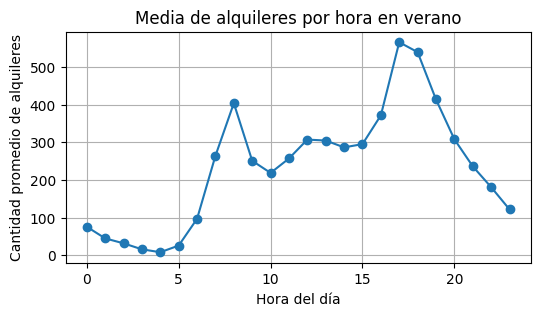

In [14]:
# Celda 2.3 - "season"=3 escriba su código y hallazgos 
summer_rentals = bikes[bikes['season'] == 3].groupby('hour').total.mean()
plt.figure(figsize=(6, 3))
plt.plot(summer_rentals.index, summer_rentals.values, marker='o')
plt.title('Media de alquileres por hora en verano')
plt.xlabel('Hora del día')
plt.ylabel('Cantidad promedio de alquileres')
plt.grid(True)
plt.show()

De acuerdo con los graficos obtenidos tanto para la temporada de invierno como la de verano, podemos decir que el compotamiento de alquiler de bicicletas por horas entre ambas temporadas es realmente similar, lo que varia son las cantidades de bicicletas alquiladas, donde vemos que las horas entre las 23 y las 5 am son las que menor alquiler de bicicletas tienen, tambien vemos un pico entre las horas 17 y 18 en ambas temporadas.

### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "season" y "hour" como las únicas variables predictoras, teniendo en cuenta que la variable "season" es categórica. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [48]:
# Celda 3
X = bikes[['season', 'hour']]
y = bikes['total']

model = LinearRegression()

# Ajustar el modelo
model.fit(X, y)

# Imprimir coeficientes
print("Coeficientes del modelo:")
print("Intercepto:", model.intercept_)
print("Coeficiente de 'season':", model.coef_[0])
print("Coeficiente de 'hour':", model.coef_[1])


Coeficientes del modelo:
Intercepto: 2.5848513346807636
Coeficiente de 'season': 26.951308510674103
Coeficiente de 'hour': 10.521298236576154


Para el coeficiente de 'season' que es de 26.9513, nos indica como cambia el numero de alquileres de bicicletas cuando se cambia de temporada y se mantiene la hora del día, es decir un aumento de una unidad en la variable "season" se asociaría, en promedio, con un aumento de aproximadamente 26.95 alquileres de bicicletas; en el caso del coeficiente de 'hour' que es de 10.5213, nos indica cómo cambia el número total de alquileres de bicicletas cuando cambiamos la hora del día, sin cambiar de temporada, es decir un aumento de una unidad en la hora del día se asociaría, en promedio, con un aumento de aproximadamente 10.52 alquileres de bicicletas.

En conclusion, el modelo nos sugiere que tanto la hora del día como la temporada tienen un impacto significativo en el número de alquileres de bicicletas. 

Algunas limitaciones de la regresión lineal en este ejercicio:

* No captura posibles interacciones no lineales entre las variables predictoras.
* Subestimación de la complejidad del fenómeno y es que la regresión lineal es un modelo simple que puede subestimar la complejidad del fenómeno que se está estudiando, en este caso, los datos de alquiler de bicicletas, pueden existir patrones no lineales o interacciones más complejas entre las variables predictoras que no pueden ser capturadas adecuadamente por un modelo lineal.

### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "season". El árbol debe tener al menos 6 nodos finales.

In [49]:
X = bikes[['season', 'hour']]
y = bikes['total']

In [50]:
# Definición de parámetros y criterios de parada
max_depth = None
num_pct = 10
max_features = None
min_gain=0.001

Variable Hour

In [51]:
# Impresión variable a usar (hour)
j = 1
print(X.columns[j])

hour


In [52]:
# División de la variable hours en num_ctp puntos (parámetro definido anteriormente) para obtener posibles puntos de corte
splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / num_pct).tolist())
splits = np.unique(splits)
splits

array([ 0.,  2.,  4.,  7.,  9., 12., 14., 16., 19., 21.])

In [53]:
# División de las observaciones usando el punto de corte en la posición 5 de la lista de splits
k=5
filter_l = X.iloc[:, j] < splits[k]

# División de la variable de respuesta de acuerdo a si la observación cumple o no con la regla binaria
# y_l: la observación tiene un valor menor al punto de corte seleccionado
# y_r: la observación tiene un valor mayor o igual al punto de corte seleccionado
y_l = y.loc[filter_l]
y_r = y.loc[~filter_l]

In [54]:
# Definición de la función que calcula el gini index
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)

In [55]:
# Gini index de las observaciones que tienen un valor menor al punto de corte seleccionado
gini_l = gini(y_l)
gini_l

-27775.88300816515

In [56]:
# Gini index de las observaciones que tienen un valor mayor o igual al punto de corte seleccionado
gini_r = gini(y_r)
gini_r

-138889.2339678902

In [57]:
# Definición de la función gini_imputiry para calular la ganancia de una variable predictora j dado el punto de corte k
def gini_impurity(X_col, y, split):
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

In [58]:
# Ganancia de la variable 'Hours' en el punto de corte selecionado
gini_impurity(X.iloc[:, j], y, splits[k])

10610.413579790038

In [59]:
# Definición de la función best_split para calcular cuál es la mejor variable y punto de cortepara hacer la bifurcación del árbol
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # Para todas las varibles 
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

In [60]:
# Obtención de la variable 'j', su punto de corte 'split' y su ganancia 'gain'
j, split, gain = best_split(X, y, 5)
j, split, gain

(1, 8.0, 18268.811823533004)

In [61]:
# División de las observaciones usando la mejor variable 'j' y su punto de corte 'split'
filter_l = X.iloc[:, j] < split

y_l = y.loc[filter_l]
y_r = y.loc[~filter_l]

In [62]:
y.shape[0], y_l.shape[0], y_r.shape[0]

(10886, 3594, 7292)

In [30]:
y.mean(), y_l.mean(), y_r.mean()

(191.57413191254824, 55.437673900946024, 258.6715578716402)

In [63]:
# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace 
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

In [64]:
# Aplicación de la función tree_grow
tree_grow(X, y, level=0, min_gain=0.001, max_depth=1, num_pct=10)

{'y_pred': 1,
 'y_prob': 191.53903379867745,
 'level': 0,
 'split': [1, 8.0],
 'n_samples': 10886,
 'gain': 18268.811823533004,
 'sl': {'y_pred': 1,
  'y_prob': 55.40711902113459,
  'level': 1,
  'split': -1,
  'n_samples': 3594,
  'gain': 7207.700659959655},
 'sr': {'y_pred': 1,
  'y_prob': 258.6007677543186,
  'level': 1,
  'split': -1,
  'n_samples': 7292,
  'gain': 7392.920792160614}}

In [65]:
tree = tree_grow(X, y, level=0, min_gain=0.001, max_depth=3, num_pct=10)
tree

{'y_pred': 1,
 'y_prob': 191.53903379867745,
 'level': 0,
 'split': [1, 8.0],
 'n_samples': 10886,
 'gain': 18268.811823533004,
 'sl': {'y_pred': 1,
  'y_prob': 55.40711902113459,
  'level': 1,
  'split': [1, 7.0],
  'n_samples': 3594,
  'gain': 7207.700659959655,
  'sl': {'y_pred': 1,
   'y_prob': 32.561604584527224,
   'level': 2,
   'split': [1, 6.0],
   'n_samples': 3139,
   'gain': 646.8008927589567,
   'sl': {'y_pred': 1,
    'y_prob': 25.15934475055845,
    'level': 3,
    'split': -1,
    'n_samples': 2684,
    'gain': 382.8088308604629},
   'sr': {'y_pred': 1,
    'y_prob': 75.92778993435448,
    'level': 3,
    'split': -1,
    'n_samples': 455,
    'gain': 743.095592335012}},
  'sr': {'y_pred': 1,
   'y_prob': 212.18599562363238,
   'level': 2,
   'split': [0, 2.0],
   'n_samples': 455,
   'gain': 5197.1071057533845,
   'sl': {'y_pred': 1,
    'y_prob': 122.27826086956522,
    'level': 3,
    'split': -1,
    'n_samples': 113,
    'gain': 0},
   'sr': {'y_pred': 1,
    'y_pr

In [66]:
# Definición de la función tree_predict para hacer predicciones según las variables 'X' y el árbol 'tree'

def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted


In [67]:
# Ejecución de función tree_predict
tree_predict(X, tree)

array([1., 1., 1., ..., 1., 1., 1.])

### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "season" y "hour" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Recuerde dividir los datos en conjuntos de entrenamiento y validación para esto. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de regresión y compare desempeño con el modelo del punto 3.

In [79]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
import numpy as np

# División de los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X[['season', 'hour']], y, test_size=0.2, random_state=1)

# Lista de valores para calibrar el criterio de parada de máxima profundidad (max_depth)
max_depth_range = range(1, 21)

# Lista para guardar los valores del accuracy para cada valor de máxima profundidad (max_depth)
accuracy_scores = []

# Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for depth in max_depth_range:
    # Definición del árbol de decisión usando DecisionTreeClassifier de la librería sklearn
    clf = DecisionTreeClassifier(max_depth=depth, random_state=1)
    # Evaluación mediante validación cruzada
    cv_scores = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
    accuracy_scores.append(np.mean(cv_scores))

# Encontrar la mejor profundidad máxima con el mejor accuracy
best_accuracy_index = np.argmax(accuracy_scores)
best_max_depth = max_depth_range[best_accuracy_index]
best_accuracy = accuracy_scores[best_accuracy_index]

print("Mejor profundidad máxima:", best_max_depth)
print("Mejor accuracy promedio:", best_accuracy)


Mejor profundidad máxima: 4
Mejor accuracy promedio: 0.02331221874711324


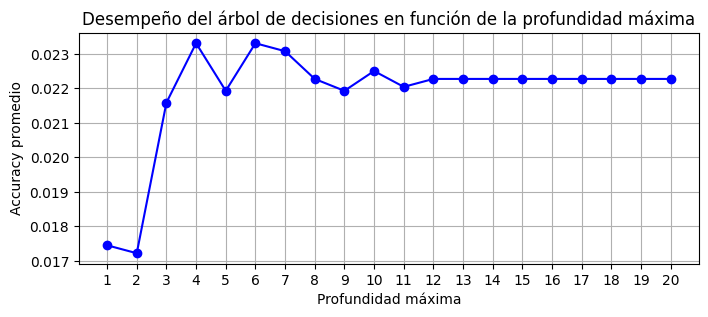

In [85]:
# Graficar los resultados
plt.figure(figsize=(8, 3))
plt.plot(max_depth_range, accuracy_scores, marker='o', linestyle='-', color='b')
plt.title('Desempeño del árbol de decisiones en función de la profundidad máxima')
plt.xlabel('Profundidad máxima')
plt.ylabel('Accuracy promedio')
plt.xticks(max_depth_range)
plt.grid(True)
plt.show()


In [86]:
# Mejor accuracy (desempeño del modelo) y su correspondiente max_depth
sorted(zip(accuracy_scores, max_depth_range))[::-1][0]

(0.02331221874711324, 4)

In [87]:
# max_depth=4 fue el mejor, se ajusta un árbol usando este valor 
clf = DecisionTreeClassifier(max_depth=4, random_state=1)
clf.fit(X, y)

DecisionTreeClassifier(max_depth=4, random_state=1)

De acuerdo con el desempeño del modelo anterior del arbol declasificación,se puede decir que con una profundidad máxima de 4, el árbol de decisiones logra un accuracy promedio del 2.33%, lo que quiere decir que el modelo es capaz de clasificar correctamente aproximadamente el 2.33% de las observaciones en el conjunto de validación, pero este resultado es minimo, lo que sugiere que el modelo puede no estar capturando bien la estructura de los datos o puede estar sobreajustando; y comparado con el modelo del punto 3, donde se obtuvieron coeficientes significativos para las variables predictoras (season y hour), el modelo de regresión lineal parece proporcionar una mejor comprensión de cómo estas variables influyen en la variable de respuesta en comparación con el modelo de clasificación basado en árboles de decisión.

## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la popularidad está dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el siguiente enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [88]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com//Dsharlie/ML-NLP/main/datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [89]:
# Definición variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']
y.mean()

0.5

In [90]:
# División de la muestra en set de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

In [91]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

# Árbol de decisión
# Crear el clasificador de árbol de decisión con un parámetro de profundidad máxima igual a 5
tree_clf = DecisionTreeClassifier(max_depth=5)
# Entrenar el modelo
tree_clf.fit(X_train, y_train)
# Predecir en el conjunto de prueba
y_pred_tree = tree_clf.predict(X_test)
# Calcular la precisión y la puntuación F1
accuracy_tree = accuracy_score(y_test, y_pred_tree)
f1_tree = f1_score(y_test, y_pred_tree)

print("Árbol de decisión:")
print("Precisión (Accuracy):", accuracy_tree)
print("Puntuación F1:", f1_tree)

# Regresión logística
# Crear el clasificador de regresión logística
log_reg = LogisticRegression()
# Entrenar el modelo
log_reg.fit(X_train, y_train)
# Predecir en el conjunto de prueba
y_pred_log_reg = log_reg.predict(X_test)
# Calcular la precisión y la puntuación F1
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
f1_log_reg = f1_score(y_test, y_pred_log_reg)

print("Regresión logística:")
print("Precisión (Accuracy):", accuracy_log_reg)
print("Puntuación F1:", f1_log_reg)


Árbol de decisión:
Precisión (Accuracy): 0.64
Puntuación F1: 0.6633416458852868
Regresión logística:
Precisión (Accuracy): 0.6126666666666667
Puntuación F1: 0.6087542087542087


### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged donde:

-las primeras 100 muestras vienen de árboles de decisión donde max_depth tome un valor de su elección\
-las segundas 100 muestras vienen de árboles de decisión donde min_samples_leaf tome un valor de su elección\
-las últimas 100 muestras vienen de regresiones logísticas

Evalúe cada uno de los tres modelos de manera independiente utilizando las métricas de Accuracy y F1-Score, luego evalúe el ensamble de modelos y compare los resultados. 

Nota: 

Para este ensamble de 300 modelos, deben hacer votación mayoritaria. Esto lo pueden hacer de distintas maneras. La más "fácil" es haciendo la votación "manualmente", como se hace a partir del minuto 5:45 del video de Ejemplo práctico de emsablajes en Coursera. Digo que es la más fácil porque si hacen la votación mayoritaria sobre las 300 predicciones van a obtener lo que se espera.

Otra opción es: para cada uno de los 3 tipos de modelos, entrenar un ensamble de 100 modelos cada uno. Predecir para cada uno de esos tres ensambles y luego predecir como un ensamble de los 3 ensambles. La cuestión es que la votación mayoritaria al usar los 3 ensambles no necesariamente va a generar el mismo resultado que si hacen la votación mayoritaria directamente sobre los 300 modelos. Entonces, para los que quieran hacer esto, deben hacer ese último cálculo con cuidado.

Para los que quieran hacerlo como ensamble de ensambles, digo que se debe hacer el ensamble final con cuidado por lo siguiente. Supongamos que:

* para los 100 árboles del primer tipo, la votación mayoritaria es: 55% de los modelos predicen que la clase de una observación es "1"
* para los 100 árboles del segundo tipo, la votación mayoritaria es: 55% de los modelos predicen que la clase de una observación es "1"
* para las 100 regresiones logísticas, la votación mayoritaria es: 10% de los modelos predicen que la clase de una observación es "1"

Si se hace la votación mayoritaria de los 300 modelos, la predicción de esa observación debería ser: (100*55%+100*55%+100*10%)/300 = 40% de los modelos votan porque la predicción debería ser "1". Es decir, la predicción del ensamble es "0" (dado que menos del 50% de modelos predijo un 1).

Sin embargo, si miramos cada ensamble por separado, el primer ensamble predice "1", el segundo ensamble predice "1" y el último ensamble predice "0". Si hago votación mayoritaria sobre esto, la predicción va a ser "1", lo cual es distinto a si se hace la votación mayoritaria sobre los 300 modelos.

In [92]:
# Celda 7
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

# Entrenar 100 árboles de decisión con diferentes valores de max_depth
tree_models_max_depth = []
for _ in range(100):
    tree_model = DecisionTreeClassifier(max_depth=5)
    tree_model.fit(X_train, y_train)
    tree_models_max_depth.append(tree_model)

# Entrenar 100 árboles de decisión con diferentes valores de min_samples_leaf
tree_models_min_samples_leaf = []
for _ in range(100):
    tree_model = DecisionTreeClassifier(min_samples_leaf=5)
    tree_model.fit(X_train, y_train)
    tree_models_min_samples_leaf.append(tree_model)

# Entrenar 100 modelos de regresión logística
logistic_models = []
for _ in range(100):
    logistic_model = LogisticRegression()
    logistic_model.fit(X_train, y_train)
    logistic_models.append(logistic_model)

# Realizar predicciones con cada conjunto de modelos
tree_predictions_max_depth = [model.predict(X_test) for model in tree_models_max_depth]
tree_predictions_min_samples_leaf = [model.predict(X_test) for model in tree_models_min_samples_leaf]
logistic_predictions = [model.predict(X_test) for model in logistic_models]

# Calcular la votación mayoritaria para cada conjunto de predicciones
ensemble_predictions = []
for i in range(len(y_test)):
    votes = np.sum([tree_predictions_max_depth[j][i] for j in range(100)]) + \
            np.sum([tree_predictions_min_samples_leaf[j][i] for j in range(100)]) + \
            np.sum([logistic_predictions[j][i] for j in range(100)])
    majority_vote = 1 if votes > 150 else 0  # Umbral de 150 votos para la votación mayoritaria
    ensemble_predictions.append(majority_vote)

# Calcular métricas para el ensamble de modelos
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
ensemble_f1 = f1_score(y_test, ensemble_predictions)

print("Ensemble de Votación Mayoritaria:")
print("Precisión (Accuracy):", ensemble_accuracy)
print("Puntuación F1:", ensemble_f1)


Ensemble de Votación Mayoritaria:
Precisión (Accuracy): 0.622
Puntuación F1: 0.631099544567339


### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

In [93]:
# Celda 8
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

# Entrenar 100 árboles de decisión con diferentes valores de max_depth
tree_models_max_depth = []
for _ in range(100):
    tree_model = DecisionTreeClassifier(max_depth=5)
    tree_model.fit(X_train, y_train)
    tree_models_max_depth.append(tree_model)

# Entrenar 100 árboles de decisión con diferentes valores de min_samples_leaf
tree_models_min_samples_leaf = []
for _ in range(100):
    tree_model = DecisionTreeClassifier(min_samples_leaf=5)
    tree_model.fit(X_train, y_train)
    tree_models_min_samples_leaf.append(tree_model)

# Entrenar 100 modelos de regresión logística
logistic_models = []
for _ in range(100):
    logistic_model = LogisticRegression()
    logistic_model.fit(X_train, y_train)
    logistic_models.append(logistic_model)

# Realizar predicciones con cada conjunto de modelos
tree_predictions_max_depth = [model.predict(X_test) for model in tree_models_max_depth]
tree_predictions_min_samples_leaf = [model.predict(X_test) for model in tree_models_min_samples_leaf]
logistic_predictions = [model.predict(X_test) for model in logistic_models]

# Calcular predicciones ponderadas para cada conjunto de modelos
weighted_predictions = []
for i in range(len(y_test)):
    weighted_vote = (np.sum([tree_predictions_max_depth[j][i] for j in range(100)]) * 0.4) + \
                    (np.sum([tree_predictions_min_samples_leaf[j][i] for j in range(100)]) * 0.4) + \
                    (np.sum([logistic_predictions[j][i] for j in range(100)]) * 0.2)
    weighted_prediction = 1 if weighted_vote > 0.5 else 0  # Umbral de 0.5 para la votación ponderada
    weighted_predictions.append(weighted_prediction)

# Calcular métricas para el ensamble de modelos con votación ponderada
weighted_accuracy = accuracy_score(y_test, weighted_predictions)
weighted_f1 = f1_score(y_test, weighted_predictions)

print("Ensemble de Votación Ponderada:")
print("Precisión (Accuracy):", weighted_accuracy)
print("Puntuación F1:", weighted_f1)


Ensemble de Votación Ponderada:
Precisión (Accuracy): 0.59
Puntuación F1: 0.6841294298921418


### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

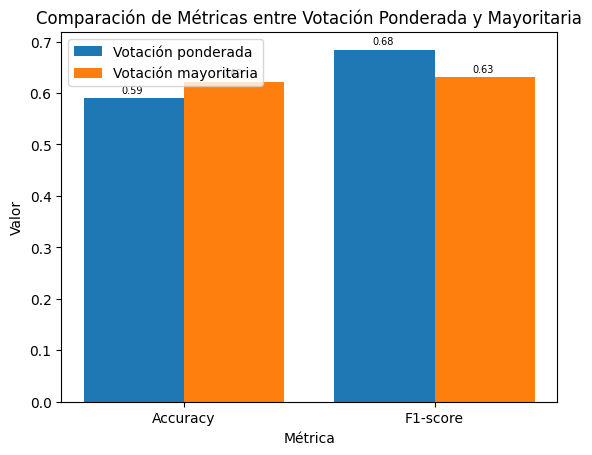

In [94]:
# Nombres de las métricas
metrics_names = ['Accuracy', 'F1-score']

# Valores de las métricas para cada método
weighted_metrics = [weighted_accuracy, weighted_f1]
ensemble_metrics = [ensemble_accuracy, ensemble_f1]

# Posiciones de las barras en el eje x
x = range(len(metrics_names))

# Ancho de las barras
bar_width = 0.4

# Crear el gráfico de barras
plt.bar(x, weighted_metrics, width=bar_width, label='Votación ponderada', align='center')
plt.bar([i + bar_width for i in x], ensemble_metrics, width=bar_width, label='Votación mayoritaria', align='center')

# Añadir etiquetas de datos a las barras
for i in range(len(x)):
    plt.text(x[i] - 0.05, weighted_metrics[i] + 0.01, '{:.2f}'.format(weighted_metrics[i]), fontsize=7)
    plt.text(x[i] + bar_width - 0.05, ensemble_metrics[i] + 0.01, '{:.2f}'.format(ensemble_metrics[i]), fontsize=7)

# Añadir etiquetas, título y leyenda
plt.xlabel('Métrica')
plt.ylabel('Valor')
plt.title('Comparación de Métricas entre Votación Ponderada y Mayoritaria')
plt.xticks([i + bar_width / 2 for i in x], metrics_names)
plt.legend()

# Mostrar el gráfico
plt.show()

De acuerdo con los resultados obtenidos, se puede decir lo siguiente:

Para el ensemble de Votación Mayoritaria donde obtuvimos:

Precisión (Accuracy): 0.6207
Puntuación F1: 0.6303

Se puede decir que las ventajas son que es simple de implementar y comprender, tambien puede ser más robusto frente a la presencia de modelos débiles o ruido en los datos y sus desventajas son que ignora las diferencias en la calidad de las predicciones de los modelos individuales, tratando todos los modelos por igual y no considera la incertidumbre asociada con las predicciones de cada modelo base.

Para el ensemble de Votación Ponderada donde se obtuvo:

Precisión (Accuracy): 0.5900
Puntuación F1: 0.6841

Sus ventajas son que permite asignar pesos diferentes a los modelos base según su desempeño o confianza en las predicciones, tambien puede mejorar el rendimiento al dar más influencia a los modelos más precisos y sus desventajas, son que requiere una calibración adecuada de los pesos, lo que puede ser subjetivo y dependiente del problema y puede ser sensible a errores en la estimación de los pesos, lo que podría conducir a un peor rendimiento si los pesos se asignan incorrectamente.
